# Library

In [28]:
import numpy as np
import torch
import torch.nn as nn

import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device {device}")

Working on device cuda


# Load dataset

In [29]:
# Transform image to 1x784 and normalize colors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
trainset = datasets.MNIST('dataset', download=False, train=True, transform=transform)
valset = datasets.MNIST('dataset', download=False, train=False, transform=transform)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3000, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=3000, shuffle=True)

for idx, (data, target) in enumerate(trainloader):
    data = data.to(device)
    target = target.to(device)

for idx, (data, target) in enumerate(valloader):
    data = data.to(device)
    target = target.to(device)    

# Preliminary computation

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])


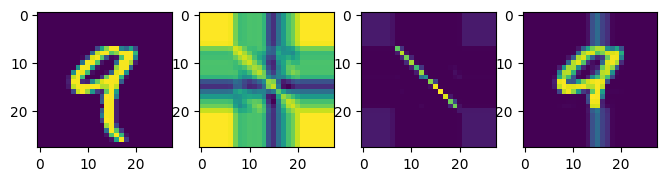

In [30]:
img, label = trainset[4]
input_size = img.shape[1:]

Q = img.clone()
K = img.clone()
V = img.clone()

soft_max = nn.Softmax(dim=2)

QT = torch.transpose(Q, 1, 2)

qTk = torch.bmm(QT, K)
atten_weight = soft_max(qTk)

Att_pool = torch.bmm(atten_weight, V)

fig, ax = plt.subplots(figsize=(8,2), nrows=1, ncols=4)
plt.subplot(1,4,1)
plt.imshow(Q.squeeze(0))
plt.subplot(1,4,2)
plt.imshow(qTk.squeeze(0))
plt.subplot(1,4,3)
plt.imshow(atten_weight.squeeze(0))

plt.subplot(1,4,4)
plt.imshow(Att_pool.squeeze(0))
Att_pool = Att_pool.squeeze(0)
print(atten_weight.sum(dim=2))

# Model description

$$ \mathrm{Attention}(\mathbf{q},\mathbf{k},\mathbf{v}) = \sum_{i=1}^m{\alpha(\mathbf{q},\mathbf{k}_i) \mathbf{v}_i} $$

where $\mathbf{q}, \mathbf{k}, \mathbf{v} \in \mathbb{R}^d$.

Scaled dot product attention scoring function:

$$ a(\mathbf{q},\mathbf{k}_i) = \mathbf{q}^T \mathbf{k}_i / \sqrt{d} $$

Attention weights

$$ \alpha(\mathbf{q},\mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q},\mathbf{k}_i)) = \frac{\exp(\mathbf{q}^T \mathbf{k}_i / \sqrt{d})}{\sum_{j=1}\exp(\mathbf{q}^T \mathbf{k}_j / \sqrt{d})}$$

In [44]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    # def __init__(self, dropout):
    def __init__(self):
        super().__init__()
        # self.dropout = nn.Dropout(dropout)
        self.soft_max = nn.Softmax(dim=2)
        

    # Shape of queries: (batch_size, img-height, d)
    # Shape of keys: (batch_size, img-height, d)
    # Shape of values: (batch_size, img-height, value dimension)
    def forward(self, queries, keys, values):
        d = queries.shape[2]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / np.sqrt(d)
        self.attention_weights = self.soft_max(scores)
        # return torch.bmm(self.dropout(self.attention_weights), values)
        return torch.bmm(self.attention_weights, values)

class sa_NN(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(sa_NN, self).__init__()
        d_model = input_size
        self.W_q = nn.Linear(input_size, d_model, device=device)
        self.W_k = nn.Linear(input_size, d_model, device=device)
        self.W_v = nn.Linear(input_size, d_model, device=device)
        self.W_o = nn.Linear(input_size*input_size, num_classes, device=device)
        
        self.num_classes = num_classes
        
        self.SDPA = DotProductAttention()

        self.log_softmax = nn.LogSoftmax(dim=1)

        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)

    def forward(self, x):
        # Multiply input by weights and add biases
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        out = self.SDPA(Q, K, V)
        out = out.reshape(out.shape[0],-1)
        # out = nn.functional.softmax(self.W_o(out),dim=0)
        out = self.log_softmax(self.W_o(out))
        
        return out

# Train loop

In [53]:
# Build the Neural Network
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

model = sa_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load('model_backup\sa_NN_epoch_100.pth'))
# model = torch.load('model_backup\sa_NN_epoch_100.pth')
# print(model)
model.to(device)

# criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss which includes softmax
criterion = nn.NLLLoss()  # Use CrossEntropyLoss which includes softmax
# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# Track MSE and loss
mse_list = []
loss_list = []

# Training the network
epochs = 200
time0 = time()

for epoch in range(epochs):
    running_loss = 0
    mse_loss = 0
    for images, labels in tqdm(trainloader, leave=False):
    # for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.squeeze(1)                 
        
        labels.to(device)

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)               
        
        # This is where the model learns by back propagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()

    
    CE_curr = running_loss / len(trainloader)
    loss_list.append(CE_curr)
    if (epoch%5)==0:
        print(f"Epoch {epoch+1} - Training loss: {CE_curr:.7f}")
    
print(f"\nTraining Time (in minutes) = {(time()-time0)/60}")

# Convert lists to numpy arrays
loss_array = np.array(loss_list)
mse_array = np.array(mse_list)

# Save arrays to .npy files
np.save('loss_values.npy', loss_array)
np.save('mse_values.npy', mse_array)

# Save the model
torch.save(model.state_dict(), f'model_backup\sa_NN_epoch_{epochs}.pth')


Epoch 1 - Training loss: 0.3241545


Epoch 6 - Training loss: 0.3206928


Epoch 11 - Training loss: 0.3181923


Epoch 16 - Training loss: 0.3161185


Epoch 21 - Training loss: 0.3138508


Epoch 26 - Training loss: 0.3115831


Epoch 31 - Training loss: 0.3098513


Epoch 36 - Training loss: 0.3083789


Epoch 41 - Training loss: 0.3062905


Epoch 46 - Training loss: 0.3043491


Epoch 51 - Training loss: 0.3029831


Epoch 56 - Training loss: 0.3011336


Epoch 61 - Training loss: 0.2992988


Epoch 66 - Training loss: 0.2980819


Epoch 71 - Training loss: 0.2968372


Epoch 76 - Training loss: 0.2953965


Epoch 81 - Training loss: 0.2943706


Epoch 86 - Training loss: 0.2929594


Epoch 91 - Training loss: 0.2914488


Epoch 96 - Training loss: 0.2906377


Epoch 101 - Training loss: 0.2891438


Epoch 106 - Training loss: 0.2881084


Epoch 111 - Training loss: 0.2871911


Epoch 116 - Training loss: 0.2861299


Epoch 121 - Training loss: 0.2850831


Epoch 126 - Training loss: 0.2839146


Epoch 131 - Training loss: 0.2829088


Epoch 136 - Training loss: 0.2820007


Epoch 141 - Training loss: 0.2809534


Epoch 146 - Training loss: 0.2805168


Epoch 151 - Training loss: 0.2797512


Epoch 156 - Training loss: 0.2785672


Epoch 161 - Training loss: 0.2776151


Epoch 166 - Training loss: 0.2768777


Epoch 171 - Training loss: 0.2760584


Epoch 176 - Training loss: 0.2752696


Epoch 181 - Training loss: 0.2744360


Epoch 186 - Training loss: 0.2736542


Epoch 191 - Training loss: 0.2729178


Epoch 196 - Training loss: 0.2727301



Training Time (in minutes) = 27.87660386164983


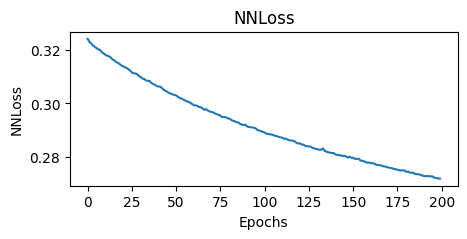

In [54]:
# Plot CE
plt.figure(figsize=(5, 2))
plt.plot(range(len(loss_array)), loss_array, label='NNLoss')
plt.xlabel('Epochs')
plt.ylabel('NNLoss')
plt.title('NNLoss')
# plt.legend()
plt.show()